In [1]:
# ============================================================
# 0. Imports & basic setup
# ============================================================

import numpy as np
import pandas as pd

import lightgbm as lgb
from xgboost import XGBRegressor, XGBClassifier

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    f1_score,
)

import matplotlib.pyplot as plt

In [2]:
# ============================================================
# 1. Load raw train data (15s resampled)
# ============================================================

train_path = "train_preprocessed_15s_stepwise.csv"   # change if needed

df_raw = pd.read_csv(train_path)
df_raw["datetime"] = pd.to_datetime(df_raw["datetime"], utc=True)

print("Raw columns:", df_raw.columns.tolist())
print(df_raw.head())
# Expected columns: ['datetime','power','fridge','home_id']

Raw columns: ['datetime', 'power', 'fridge', 'home_id']
                   datetime  power  fridge home_id
0 2012-11-09 22:28:15+00:00  599.0    85.0  home_1
1 2012-11-09 22:28:30+00:00  599.0    85.0  home_1
2 2012-11-09 22:28:45+00:00  599.0    85.0  home_1
3 2012-11-09 22:29:00+00:00  599.0    85.0  home_1
4 2012-11-09 22:29:15+00:00  599.0    85.0  home_1


In [3]:
# ============================================================
# 2. Shared feature engineering
# ============================================================

def build_features(df, on_threshold=20.0):
    """
    Build features for NILM fridge:
    - Requires: datetime, power
    - Uses: home_id if present (else creates one group)
    - If 'fridge' exists, adds is_on label.
    """
    df = df.copy()

    assert "datetime" in df.columns, "datetime missing"
    assert "power" in df.columns, "power missing"

    if "home_id" not in df.columns:
        df["home_id"] = "all_homes"
    group_col = "home_id"

    # Sort by home & time
    df = df.sort_values([group_col, "datetime"]).reset_index(drop=True)

    # --- Time features ---
    dt = df["datetime"]
    df["minute"] = dt.dt.minute
    df["hour"] = dt.dt.hour
    df["dayofweek"] = dt.dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["dow_sin"]  = np.sin(2*np.pi*df["dayofweek"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["dayofweek"]/7)

    # --- Clip mains power (remove extreme spikes) ---
    upper_clip = df["power"].quantile(0.999)
    df["power_clip"] = df["power"].clip(lower=0, upper=upper_clip)

    grp = df.groupby(group_col)

    # --- Lags on mains ---
    LAGS = [1, 2, 4, 8, 16, 32, 64, 128]
    for lag in LAGS:
        df[f"power_lag_{lag}"] = grp["power_clip"].shift(lag)

    # --- Rolling stats on mains ---
    WINDOWS = [4, 16, 64]   # 1, 4, 16 minutes
    for w in WINDOWS:
        roll = grp["power_clip"].rolling(w)
        df[f"power_roll_mean_{w}"] = roll.mean().reset_index(level=0, drop=True)
        df[f"power_roll_std_{w}"]  = roll.std().reset_index(level=0, drop=True)
        df[f"power_roll_min_{w}"]  = roll.min().reset_index(level=0, drop=True)
        df[f"power_roll_max_{w}"]  = roll.max().reset_index(level=0, drop=True)

    # --- Differences (edges) ---
    df["power_diff_1"] = grp["power_clip"].diff(1)
    df["power_diff_4"] = grp["power_clip"].diff(4)
    df["power_diff_8"] = grp["power_clip"].diff(8)

    # --- Classification target if fridge exists ---
    if "fridge" in df.columns:
        df["is_on"] = (df["fridge"] > on_threshold).astype(int)

    return df


df_feat = build_features(df_raw, on_threshold=20.0)

# Drop rows with NaNs from lags/rolling before modeling
df_model = df_feat.dropna().reset_index(drop=True)
print("Shape after feature engineering & dropna:", df_model.shape)
print("Houses in train:", df_model["home_id"].unique())

Shape after feature engineering & dropna: (7853441, 37)
Houses in train: ['home_1' 'home_2' 'home_4' 'home_5']


In [4]:
# ============================================================
# 3. Define features and targets (no leakage)
# ============================================================

target_reg = "fridge"
target_cls = "is_on"

exclude_cols = [
    "datetime",
    "home_id",
    "fridge",
    "is_on",
    "power",     # use power_clip instead
    "fridge_Wh",
    "date",
    # any additional debug/cycle cols if they exist in your df
    "state_change",
    "cycle_id",
    "run_length",
    "on_run_length",
    "off_run_length",
]
exclude_cols = [c for c in exclude_cols if c in df_model.columns]

feature_cols = [c for c in df_model.columns if c not in exclude_cols]

print("Num features:", len(feature_cols))
print("Fridge-like features:", [c for c in feature_cols if "fridge" in c.lower()])
print("ON-like features:", [c for c in feature_cols if "is_on" in c.lower()])

# Quick correlation sanity check
corr_with_target = (
    df_model[feature_cols + [target_reg]]
    .corr()[target_reg]
    .drop(target_reg)
    .abs()
    .sort_values(ascending=False)
)
print("\nTop 10 |corr(feature, fridge)|:")
print(corr_with_target.head(10))

# Class imbalance weight for ON/OFF
pos = (df_model[target_cls] == 1).sum()
neg = (df_model[target_cls] == 0).sum()
scale_pos_weight = neg / max(pos, 1)

print(f"\nClass balance: pos={pos}, neg={neg}, scale_pos_weight={scale_pos_weight:.2f}")

Num features: 32
Fridge-like features: []
ON-like features: []

Top 10 |corr(feature, fridge)|:
power_roll_min_16     0.107305
power_roll_min_4      0.105989
power_clip            0.105466
power_roll_mean_4     0.105356
power_lag_1           0.104615
power_roll_min_64     0.103833
power_lag_2           0.103764
power_roll_mean_16    0.103486
power_roll_max_4      0.102602
power_lag_4           0.102019
Name: fridge, dtype: float64

Class balance: pos=3123584, neg=4729857, scale_pos_weight=1.51



================= LIGHTGBM: VALIDATING ON home_1 =================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 3324341, number of used features: 32
[LightGBM] [Info] Start training from score 33.753987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	valid_0's l1: 31.8363	valid_0's l2: 1815.5
[LightGBM] [Info] Number of positive: 1049357, number of negative: 2274984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in

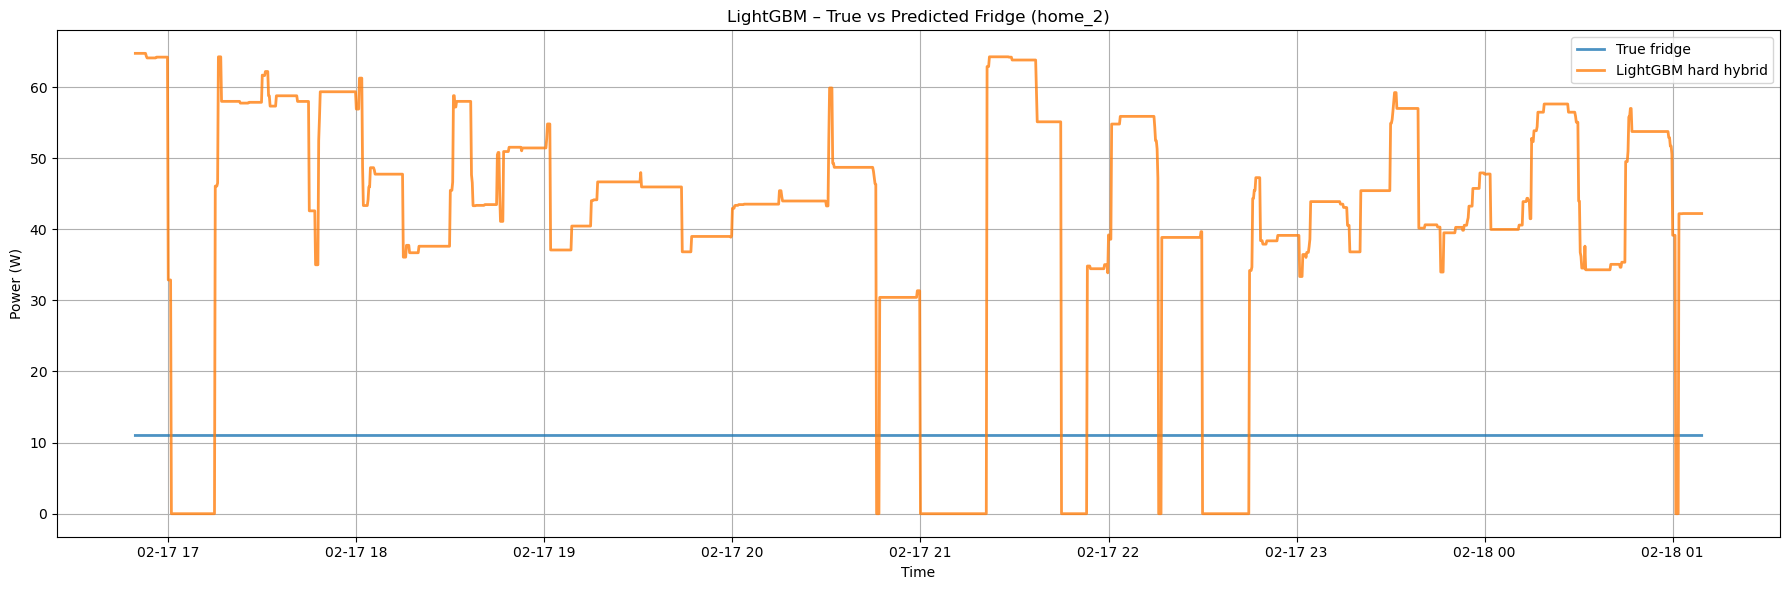


================= LIGHTGBM: VALIDATING ON home_4 =================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6266
[LightGBM] [Info] Number of data points in the train set: 6669268, number of used features: 32
[LightGBM] [Info] Start training from score 41.160661
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's l1: 24.4097	valid_0's l2: 1102.49
[LightGBM] [Info] Number of positive: 2786892, number of negative: 3882376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6266
[LightGBM] [Info] Number of data points i

In [5]:
# ============================================================
# 4. LOHO CV: LightGBM regression + classifier + hybrid
# ============================================================

houses = df_model["home_id"].unique()
results_lgbm = []

for val_house in houses:
    print(f"\n================= LIGHTGBM: VALIDATING ON {val_house} =================")

    train_fold = df_model[df_model["home_id"] != val_house]
    valid_fold = df_model[df_model["home_id"] == val_house]

    # Safety checks
    assert val_house not in train_fold["home_id"].unique()
    assert len(set(train_fold.index).intersection(set(valid_fold.index))) == 0

    X_train = train_fold[feature_cols]
    y_train_reg = train_fold[target_reg]
    y_train_cls = train_fold[target_cls]

    X_valid = valid_fold[feature_cols]
    y_valid_reg = valid_fold[target_reg]
    y_valid_cls = valid_fold[target_cls]

    # --- 4.1 Regression model ---
    reg_lgbm = lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=50,
        objective="regression",
        random_state=42,
        n_jobs=-1,
    )

    reg_lgbm.fit(
        X_train,
        y_train_reg,
        eval_set=[(X_valid, y_valid_reg)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(100)],
    )

    reg_pred = reg_lgbm.predict(X_valid)
    mae_reg = mean_absolute_error(y_valid_reg, reg_pred)
    rmse_reg = np.sqrt(mean_squared_error(y_valid_reg, reg_pred))

    # --- 4.2 Classification model ---
    cls_lgbm = lgb.LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=50,
        objective="binary",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
    )

    cls_lgbm.fit(
        X_train,
        y_train_cls,
        eval_set=[(X_valid, y_valid_cls)],
        eval_metric="binary_logloss",
        callbacks=[lgb.early_stopping(100)],
    )

    prob_on = cls_lgbm.predict_proba(X_valid)[:, 1]

    # --- 4.3 Threshold tuning ---
    thresholds = np.linspace(0.05, 0.95, 19)
    best_f1 = -1
    best_t = 0.5

    for t in thresholds:
        pred_on_t = (prob_on > t).astype(int)
        f1_t = f1_score(y_valid_cls, pred_on_t)
        if f1_t > best_f1:
            best_f1 = f1_t
            best_t = t

    pred_on_best = (prob_on > best_t).astype(int)

    # --- 4.4 Hybrid predictions ---
    hybrid_hard = reg_pred * pred_on_best
    hybrid_soft = reg_pred * prob_on

    mae_hard = mean_absolute_error(y_valid_reg, hybrid_hard)
    rmse_hard = np.sqrt(mean_squared_error(y_valid_reg, hybrid_hard))

    mae_soft = mean_absolute_error(y_valid_reg, hybrid_soft)
    rmse_soft = np.sqrt(mean_squared_error(y_valid_reg, hybrid_soft))

    print(
        f"LGBM Reg MAE={mae_reg:.2f}, Hard MAE={mae_hard:.2f}, Soft MAE={mae_soft:.2f}, "
        f"Reg RMSE={rmse_reg:.2f}, Hard RMSE={rmse_hard:.2f}, Soft RMSE={rmse_soft:.2f}, "
        f"best_t={best_t:.2f}, F1={best_f1:.3f}"
    )

    results_lgbm.append({
        "house": val_house,
        "mae_reg": mae_reg,
        "rmse_reg": rmse_reg,
        "mae_hard": mae_hard,
        "rmse_hard": rmse_hard,
        "mae_soft": mae_soft,
        "rmse_soft": rmse_soft,
        "best_t": best_t,
        "f1": best_f1,
    })

    # -------- QUALITATIVE PLOT FOR ONE HOUSE (e.g. home_2) ---------
    if val_house == "home_2":
        print("\nPlotting LightGBM predictions vs actual for", val_house)

        df_plot = valid_fold.copy().sort_values("datetime")
        df_plot["pred_hard"] = hybrid_hard

        N = 2000  # first N points to show
        df_slice = df_plot.iloc[:N]

        plt.figure(figsize=(18, 6))
        plt.plot(df_slice["datetime"], df_slice["fridge"],
                 label="True fridge", linewidth=2, alpha=0.8)
        plt.plot(df_slice["datetime"], df_slice["pred_hard"],
                 label="LightGBM hard hybrid", linewidth=2, alpha=0.8)
        plt.title(f"LightGBM – True vs Predicted Fridge ({val_house})")
        plt.xlabel("Time")
        plt.ylabel("Power (W)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

results_lgbm_df = pd.DataFrame(results_lgbm)

print("\n========== LIGHTGBM PER-HOUSE RESULTS ==========")
print(results_lgbm_df)

print("\n========== LIGHTGBM AVERAGE OVER HOUSES ==========")
print(results_lgbm_df.mean(numeric_only=True))

print("\n===== LIGHTGBM MAE per house =====")
print(results_lgbm_df[["house", "mae_reg", "mae_hard", "mae_soft"]])

In [6]:
# ============================================================
# 5. Train final LightGBM models on ALL training data + predict test
# ============================================================

X_full = df_model[feature_cols]
y_full_reg = df_model[target_reg]
y_full_cls = df_model[target_cls]

# Final regression model
reg_lgbm_final = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=50,
    objective="regression",
    random_state=42,
    n_jobs=-1,
)
reg_lgbm_final.fit(X_full, y_full_reg)

# Final classifier model
cls_lgbm_final = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=50,
    objective="binary",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
)
cls_lgbm_final.fit(X_full, y_full_cls)

# Global threshold from LGBM LOHO
global_t_lgbm = results_lgbm_df["best_t"].median()
print(f"\nGlobal ON/OFF threshold for LGBM (median best_t): {global_t_lgbm:.3f}")

# -------------------- Predict on Kaggle test ------------------

orig_test_path = "test.csv"                         # Kaggle original test
step_test_path = "test_preprocessed_15s_stepwise.csv"
submission_lgbm_path = "submission.csv"             # keep as your original name

# 1) Original test (id, datetime, power)
df_test_orig = pd.read_csv(orig_test_path)
df_test_orig["datetime"] = pd.to_datetime(df_test_orig["datetime"], utc=True)
print("Original test shape:", df_test_orig.shape)

# 2) Stepwise test
df_test_step = pd.read_csv(step_test_path)
df_test_step["datetime"] = pd.to_datetime(df_test_step["datetime"], utc=True)

if "home_id" not in df_test_step.columns:
    df_test_step["home_id"] = "test_home"

print("Stepwise test shape:", df_test_step.shape)

# 3) Features for test
df_test_feat = build_features(df_test_step, on_threshold=20.0)

feature_mask = df_test_feat[feature_cols].notna().all(axis=1)
print(f"Valid feature rows in LGBM test (stepwise): {feature_mask.sum()} / {len(df_test_feat)}")

df_test_feat["fridge_pred"] = 0.0

X_test = df_test_feat.loc[feature_mask, feature_cols]

reg_pred_test = reg_lgbm_final.predict(X_test)
prob_on_test = cls_lgbm_final.predict_proba(X_test)[:, 1]

pred_on_test = (prob_on_test > global_t_lgbm).astype(int)
hybrid_hard_test = reg_pred_test * pred_on_test

df_test_feat.loc[feature_mask, "fridge_pred"] = hybrid_hard_test
df_test_feat["fridge_pred"] = df_test_feat["fridge_pred"].clip(lower=0.0)

# 5) Map back to original timestamps
pred_step = df_test_feat[["datetime", "fridge_pred"]].sort_values("datetime")
test_orig_sorted = df_test_orig.sort_values("datetime")

df_merged = pd.merge_asof(
    test_orig_sorted,
    pred_step,
    on="datetime",
    direction="backward",
)

df_merged["fridge_pred"] = df_merged["fridge_pred"].fillna(0.0)

submission_lgbm = df_merged[["id", "fridge_pred"]].rename(columns={"fridge_pred": "fridge"})

print("\nLGBM submission head:")
print(submission_lgbm.head())
print("\nLGBM submission stats:")
print(submission_lgbm["fridge"].describe())

# Sanity checks
assert list(submission_lgbm.columns) == ["id", "fridge"], "LGBM: columns must be ['id','fridge']"
assert submission_lgbm.isna().sum().sum() == 0, "LGBM: NaNs in submission!"
assert submission_lgbm["id"].is_unique, "LGBM: IDs not unique!"
# If you know expected row count:
# assert len(submission_lgbm) == 361711

submission_lgbm.to_csv(submission_lgbm_path, index=False)
print(f"\nSaved LightGBM submission to {submission_lgbm_path}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6266
[LightGBM] [Info] Number of data points in the train set: 7853441, number of used features: 32
[LightGBM] [Info] Start training from score 38.947499
[LightGBM] [Info] Number of positive: 3123584, number of negative: 4729857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.253072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6266
[LightGBM] [Info] Number of data points in the train set: 7853441, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397734 -> initscore=-0.414914
[LightGBM] [Info] Start training from score -0.414914

Global ON/OFF threshold fo


================= XGBOOST: VALIDATING ON home_1 =================
XGB Reg MAE=31.73, Hard MAE=28.67, Soft MAE=32.21, best_t=0.25, F1=0.761

================= XGBOOST: VALIDATING ON home_2 =================
XGB Reg MAE=29.17, Hard MAE=30.02, Soft MAE=27.94, best_t=0.10, F1=0.540

Plotting XGBoost predictions vs actual for home_2


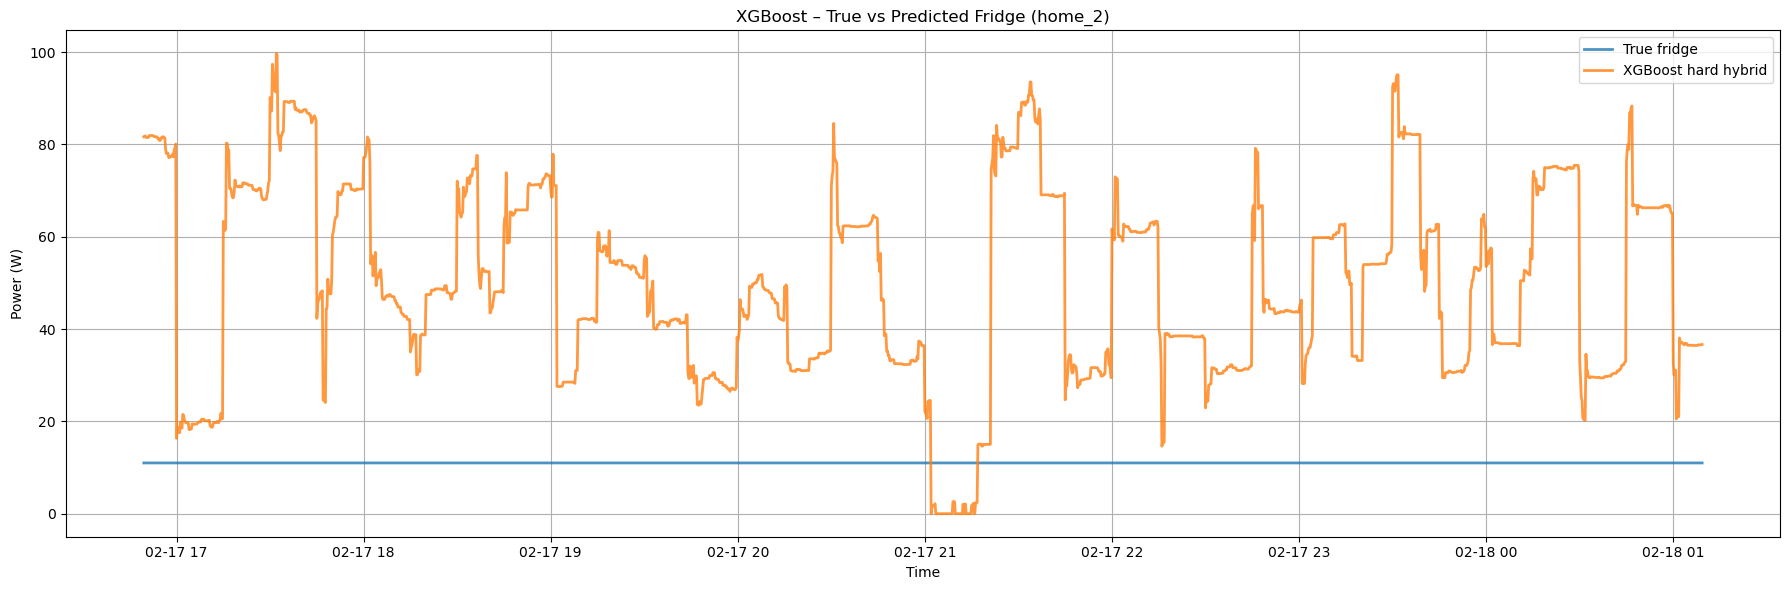


================= XGBOOST: VALIDATING ON home_4 =================
XGB Reg MAE=24.17, Hard MAE=17.98, Soft MAE=20.15, best_t=0.50, F1=0.740

================= XGBOOST: VALIDATING ON home_5 =================
XGB Reg MAE=47.37, Hard MAE=37.06, Soft MAE=42.90, best_t=0.65, F1=0.616

========== XGBOOST PER-HOUSE RESULTS ==========
    house    mae_reg   rmse_reg   mae_hard  rmse_hard   mae_soft  rmse_soft  \
0  home_1  31.731597  42.835549  28.668981  44.293123  32.210965  48.876866   
1  home_2  29.165943  39.589818  30.015571  39.972445  27.936724  40.184150   
2  home_4  24.171694  33.834092  17.979813  34.289022  20.150765  33.755860   
3  home_5  47.368945  51.086315  37.062481  53.944698  42.900276  50.950796   

   best_t        f1  
0    0.25  0.760708  
1    0.10  0.540053  
2    0.50  0.739925  
3    0.65  0.616413  

========== XGBOOST AVERAGE RESULTS ==========
mae_reg      33.109545
rmse_reg     41.836443
mae_hard     28.431712
rmse_hard    43.124822
mae_soft     30.799683
rms

In [7]:
# ============================================================
# 6. LOHO CV: XGBoost regression + classifier + hybrid
# ============================================================

houses = df_model["home_id"].unique()
results_xgb = []

for val_house in houses:
    print(f"\n================= XGBOOST: VALIDATING ON {val_house} =================")

    train_fold = df_model[df_model["home_id"] != val_house]
    valid_fold = df_model[df_model["home_id"] == val_house]

    assert val_house not in train_fold["home_id"].unique()
    assert len(set(train_fold.index).intersection(set(valid_fold.index))) == 0

    X_train = train_fold[feature_cols]
    y_train_reg = train_fold[target_reg]
    y_train_cls = train_fold[target_cls]

    X_valid = valid_fold[feature_cols]
    y_valid_reg = valid_fold[target_reg]
    y_valid_cls = valid_fold[target_cls]

    # --- 6.1 Regression (XGBRegressor) ---
    reg_xgb = XGBRegressor(
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        objective="reg:squarederror",
        tree_method="hist",
        eval_metric="mae",
        random_state=42,
        n_jobs=-1,
    )

    reg_xgb.fit(
        X_train,
        y_train_reg,
        eval_set=[(X_valid, y_valid_reg)],
        verbose=False,
    )

    reg_pred = reg_xgb.predict(X_valid)
    mae_reg = mean_absolute_error(y_valid_reg, reg_pred)
    rmse_reg = np.sqrt(mean_squared_error(y_valid_reg, reg_pred))

    # --- 6.2 Classification (XGBClassifier) ---
    cls_xgb = XGBClassifier(
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        objective="binary:logistic",
        tree_method="hist",
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    )

    cls_xgb.fit(
        X_train,
        y_train_cls,
        eval_set=[(X_valid, y_valid_cls)],
        verbose=False,
    )

    prob_on = cls_xgb.predict_proba(X_valid)[:, 1]

    # --- 6.3 Threshold tuning ---
    thresholds = np.linspace(0.05, 0.95, 19)
    best_f1 = -1
    best_t = 0.5

    for t in thresholds:
        pred_on_t = (prob_on > t).astype(int)
        f1_t = f1_score(y_valid_cls, pred_on_t)
        if f1_t > best_f1:
            best_f1 = f1_t
            best_t = t

    pred_on_best = (prob_on > best_t).astype(int)

    # --- 6.4 Hybrid predictions ---
    hybrid_hard = reg_pred * pred_on_best
    hybrid_soft = reg_pred * prob_on

    mae_hard = mean_absolute_error(y_valid_reg, hybrid_hard)
    rmse_hard = np.sqrt(mean_squared_error(y_valid_reg, hybrid_hard))

    mae_soft = mean_absolute_error(y_valid_reg, hybrid_soft)
    rmse_soft = np.sqrt(mean_squared_error(y_valid_reg, hybrid_soft))

    print(
        f"XGB Reg MAE={mae_reg:.2f}, Hard MAE={mae_hard:.2f}, Soft MAE={mae_soft:.2f}, "
        f"best_t={best_t:.2f}, F1={best_f1:.3f}"
    )

    results_xgb.append({
        "house": val_house,
        "mae_reg": mae_reg,
        "rmse_reg": rmse_reg,
        "mae_hard": mae_hard,
        "rmse_hard": rmse_hard,
        "mae_soft": mae_soft,
        "rmse_soft": rmse_soft,
        "best_t": best_t,
        "f1": best_f1,
    })

    # -------- OPTIONAL: qualitative plot for XGB (same house) --------
    if val_house == "home_2":
        print("\nPlotting XGBoost predictions vs actual for", val_house)

        df_plot = valid_fold.copy().sort_values("datetime")
        df_plot["pred_hard"] = hybrid_hard

        N = 2000
        df_slice = df_plot.iloc[:N]

        plt.figure(figsize=(18, 6))
        plt.plot(df_slice["datetime"], df_slice["fridge"],
                 label="True fridge", linewidth=2, alpha=0.8)
        plt.plot(df_slice["datetime"], df_slice["pred_hard"],
                 label="XGBoost hard hybrid", linewidth=2, alpha=0.8)
        plt.title(f"XGBoost – True vs Predicted Fridge ({val_house})")
        plt.xlabel("Time")
        plt.ylabel("Power (W)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

results_xgb_df = pd.DataFrame(results_xgb)

print("\n========== XGBOOST PER-HOUSE RESULTS ==========")
print(results_xgb_df)

print("\n========== XGBOOST AVERAGE RESULTS ==========")
print(results_xgb_df.mean(numeric_only=True))

In [8]:
# ============================================================
# 7. Train final XGBoost models on ALL data + predict test
# ============================================================

X_full = df_model[feature_cols]
y_full_reg = df_model[target_reg]
y_full_cls = df_model[target_cls]

# Final regression model
reg_xgb_final = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1,
)
reg_xgb_final.fit(X_full, y_full_reg, verbose=False)

# Final classifier model
cls_xgb_final = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    objective="binary:logistic",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)
cls_xgb_final.fit(X_full, y_full_cls, verbose=False)

global_t_xgb = results_xgb_df["best_t"].median()
print(f"\nGlobal ON/OFF threshold for XGB (median best_t): {global_t_xgb:.3f}")

# -------------------- Predict on Kaggle test ------------------

orig_test_path = "test.csv"
step_test_path = "test_preprocessed_15s_stepwise.csv"
submission_xgb_path = "submission_xgb.csv"

df_test_orig = pd.read_csv(orig_test_path)
df_test_orig["datetime"] = pd.to_datetime(df_test_orig["datetime"], utc=True)

df_test_step = pd.read_csv(step_test_path)
df_test_step["datetime"] = pd.to_datetime(df_test_step["datetime"], utc=True)

if "home_id" not in df_test_step.columns:
    df_test_step["home_id"] = "test_home"

df_test_feat = build_features(df_test_step, on_threshold=20.0)

feature_mask = df_test_feat[feature_cols].notna().all(axis=1)
print(f"Valid feature rows in XGB test (stepwise): {feature_mask.sum()} / {len(df_test_feat)}")

df_test_feat["fridge_pred"] = 0.0
X_test = df_test_feat.loc[feature_mask, feature_cols]

reg_pred_test = reg_xgb_final.predict(X_test)
prob_on_test = cls_xgb_final.predict_proba(X_test)[:, 1]

pred_on_test = (prob_on_test > global_t_xgb).astype(int)
hybrid_hard_test = reg_pred_test * pred_on_test

df_test_feat.loc[feature_mask, "fridge_pred"] = hybrid_hard_test
df_test_feat["fridge_pred"] = df_test_feat["fridge_pred"].clip(lower=0.0)

pred_step = df_test_feat[["datetime", "fridge_pred"]].sort_values("datetime")
test_orig_sorted = df_test_orig.sort_values("datetime")

df_merged_xgb = pd.merge_asof(
    test_orig_sorted,
    pred_step,
    on="datetime",
    direction="backward",
)
df_merged_xgb["fridge_pred"] = df_merged_xgb["fridge_pred"].fillna(0.0)

submission_xgb = df_merged_xgb[["id", "fridge_pred"]].rename(columns={"fridge_pred": "fridge"})

print("\nXGB submission head:")
print(submission_xgb.head())
print("\nXGB submission stats:")
print(submission_xgb["fridge"].describe())

assert list(submission_xgb.columns) == ["id", "fridge"], "XGB: columns must be ['id','fridge']"
assert submission_xgb.isna().sum().sum() == 0, "XGB: NaNs in submission!"

submission_xgb.to_csv(submission_xgb_path, index=False)
print(f"\nSaved XGBoost submission to {submission_xgb_path}")


Global ON/OFF threshold for XGB (median best_t): 0.375
Valid feature rows in XGB test (stepwise): 1019276 / 1019404

XGB submission head:
   id  fridge
0   0     0.0
1   1     0.0
2   2     0.0
3   3     0.0
4   4     0.0

XGB submission stats:
count    361711.000000
mean         43.232231
std          19.891418
min           0.000000
25%          35.987072
50%          45.562492
75%          54.664501
max         235.872803
Name: fridge, dtype: float64

Saved XGBoost submission to submission_xgb.csv


In [9]:
# ============================================================
# 8. Ensemble LGBM + XGB submissions
# ============================================================

sub_lgbm = submission_lgbm.copy().sort_values("id").reset_index(drop=True)
sub_xgb  = submission_xgb.copy().sort_values("id").reset_index(drop=True)

assert (sub_lgbm["id"] == sub_xgb["id"]).all(), "ID mismatch between LGBM and XGB!"

# You can tune these if you like; for now, equal weights:
w_lgbm = 0.5
w_xgb  = 0.5

print("Ensemble weights: LGBM =", w_lgbm, ", XGB =", w_xgb)

fridge_ens = w_lgbm * sub_lgbm["fridge"].values + w_xgb * sub_xgb["fridge"].values

FRIDGE_MAX_SAFE = 252.0  # from your earlier check
fridge_ens = np.clip(fridge_ens, 0.0, FRIDGE_MAX_SAFE)

sub_ens = pd.DataFrame({
    "id": sub_lgbm["id"],
    "fridge": fridge_ens,
})

print("\nEnsemble submission head:")
print(sub_ens.head())
print("\nEnsemble stats:")
print(sub_ens["fridge"].describe())

sub_ens.to_csv("submission_ensemble.csv", index=False)
print("\nSaved submission_ensemble.csv")

Ensemble weights: LGBM = 0.5 , XGB = 0.5

Ensemble submission head:
   id  fridge
0   0     0.0
1   1     0.0
2   2     0.0
3   3     0.0
4   4     0.0

Ensemble stats:
count    361711.000000
mean         43.284681
std          19.095140
min           0.000000
25%          36.191596
50%          45.408773
75%          54.285775
max         242.224853
Name: fridge, dtype: float64

Saved submission_ensemble.csv


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# ---------- helper for smoothing ----------
def smooth_prob(arr, window=11):
    return (
        pd.Series(arr)
        .rolling(window, center=True, min_periods=1)
        .mean()
        .clip(0, 1)
        .values
    )

# ---------- global params (recompute if needed) ----------
# thresholds from LOHO
global_t_lgbm = results_lgbm_df["best_t"].median()
global_t_xgb  = results_xgb_df["best_t"].median()

# safe fridge max for clipping
FRIDGE_MAX_SAFE = float(df_model["fridge"].quantile(0.999))
print(f"FRIDGE_MAX_SAFE: {FRIDGE_MAX_SAFE:.2f} W")

# ensemble weights (same as you used for test submission)
w_lgbm = 0.5
w_xgb  = 0.5
print(f"Ensemble weights: LGBM = {w_lgbm}, XGB = {w_xgb}")

# ---------- MAE per house ----------
houses = df_model["home_id"].unique()
ensemble_results = []

for h in houses:
    df_house = df_model[df_model["home_id"] == h].copy().sort_values("datetime")
    X_house = df_house[feature_cols]
    y_house = df_house["fridge"].values

    # ===== LGBM blended prediction =====
    reg_lgbm_h  = reg_lgbm_final.predict(X_house)
    prob_lgbm_h = cls_lgbm_final.predict_proba(X_house)[:, 1]
    prob_lgbm_hs = smooth_prob(prob_lgbm_h)

    hard_lgbm_h  = reg_lgbm_h * (prob_lgbm_hs > global_t_lgbm)
    soft_lgbm_h  = reg_lgbm_h * prob_lgbm_hs
    blend_lgbm_h = 0.5 * hard_lgbm_h + 0.5 * soft_lgbm_h

    # ===== XGB blended prediction =====
    reg_xgb_h  = reg_xgb_final.predict(X_house)
    prob_xgb_h = cls_xgb_final.predict_proba(X_house)[:, 1]
    prob_xgb_hs = smooth_prob(prob_xgb_h)

    hard_xgb_h  = reg_xgb_h * (prob_xgb_hs > global_t_xgb)
    soft_xgb_h  = reg_xgb_h * prob_xgb_hs
    blend_xgb_h = 0.5 * hard_xgb_h + 0.5 * soft_xgb_h

    # ===== Final ensemble =====
    y_pred_ens = w_lgbm * blend_lgbm_h + w_xgb * blend_xgb_h
    y_pred_ens = np.clip(y_pred_ens, 0.0, FRIDGE_MAX_SAFE)

    mae_ens = mean_absolute_error(y_house, y_pred_ens)

    ensemble_results.append({
        "house": h,
        "mae_ensemble": mae_ens,
    })

ensemble_results_df = pd.DataFrame(ensemble_results)

print("\n===== Ensemble MAE per house =====")
print(ensemble_results_df)

print("\n===== Average ensemble MAE =====")
print(ensemble_results_df["mae_ensemble"].mean())

FRIDGE_MAX_SAFE: 252.00 W
Ensemble weights: LGBM = 0.5, XGB = 0.5

===== Ensemble MAE per house =====
    house  mae_ensemble
0  home_1     21.162116
1  home_2     18.754701
2  home_4     15.285007
3  home_5     24.405094

===== Average ensemble MAE =====
19.901729551498484


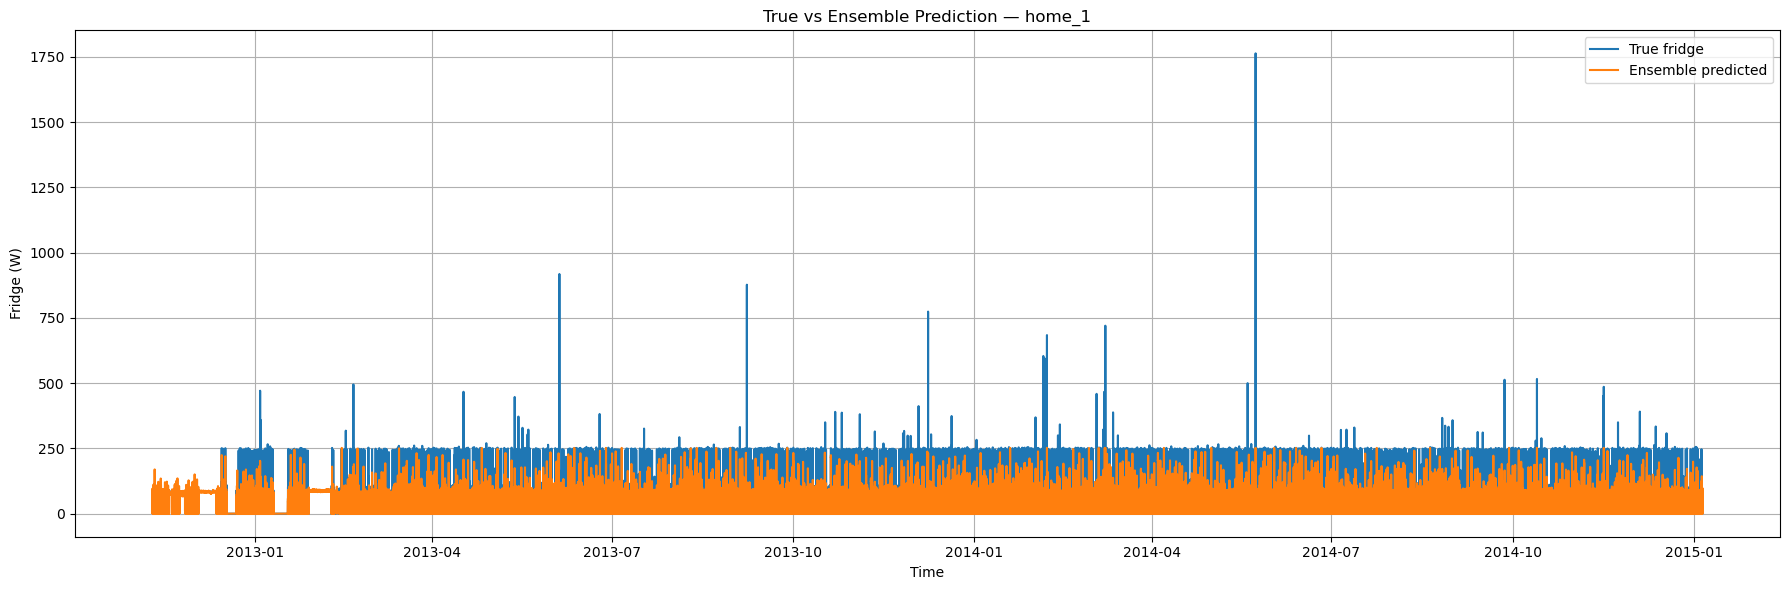

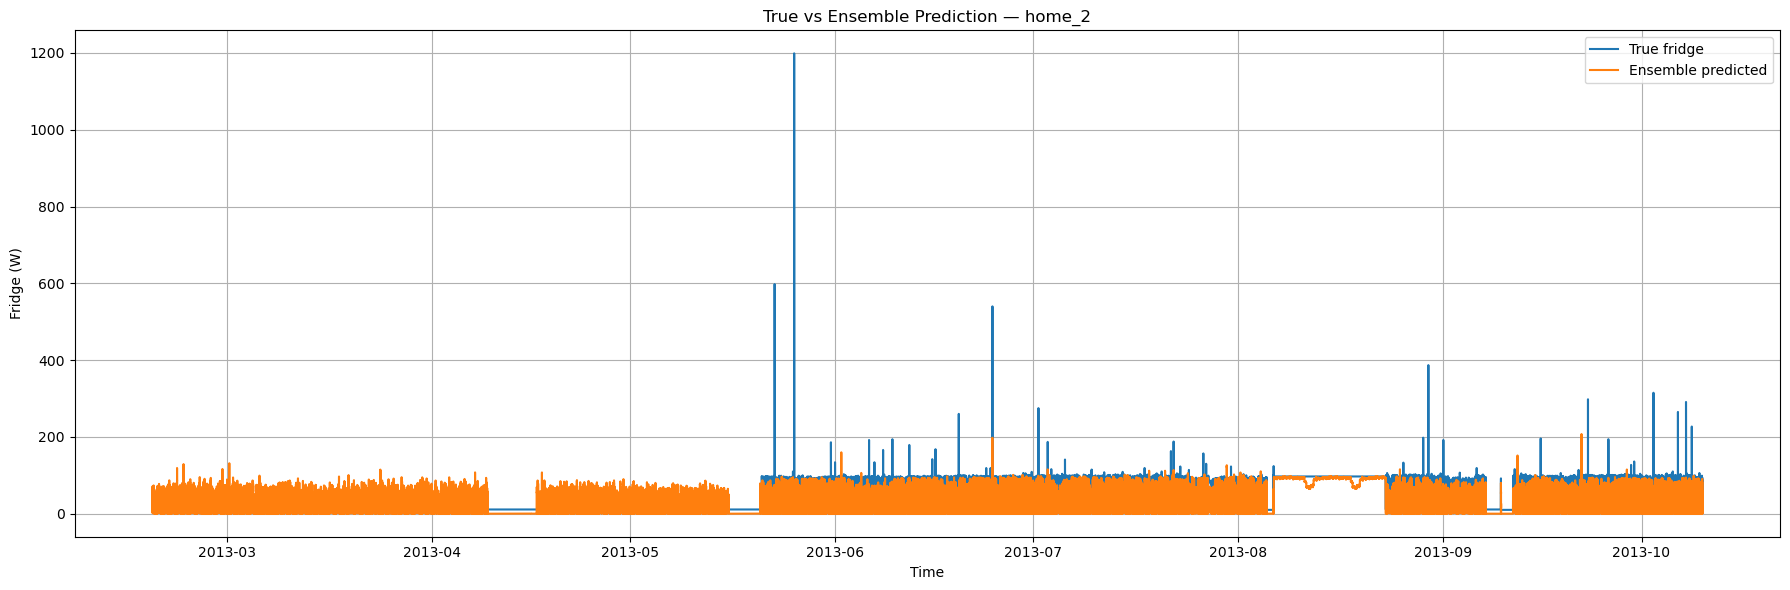

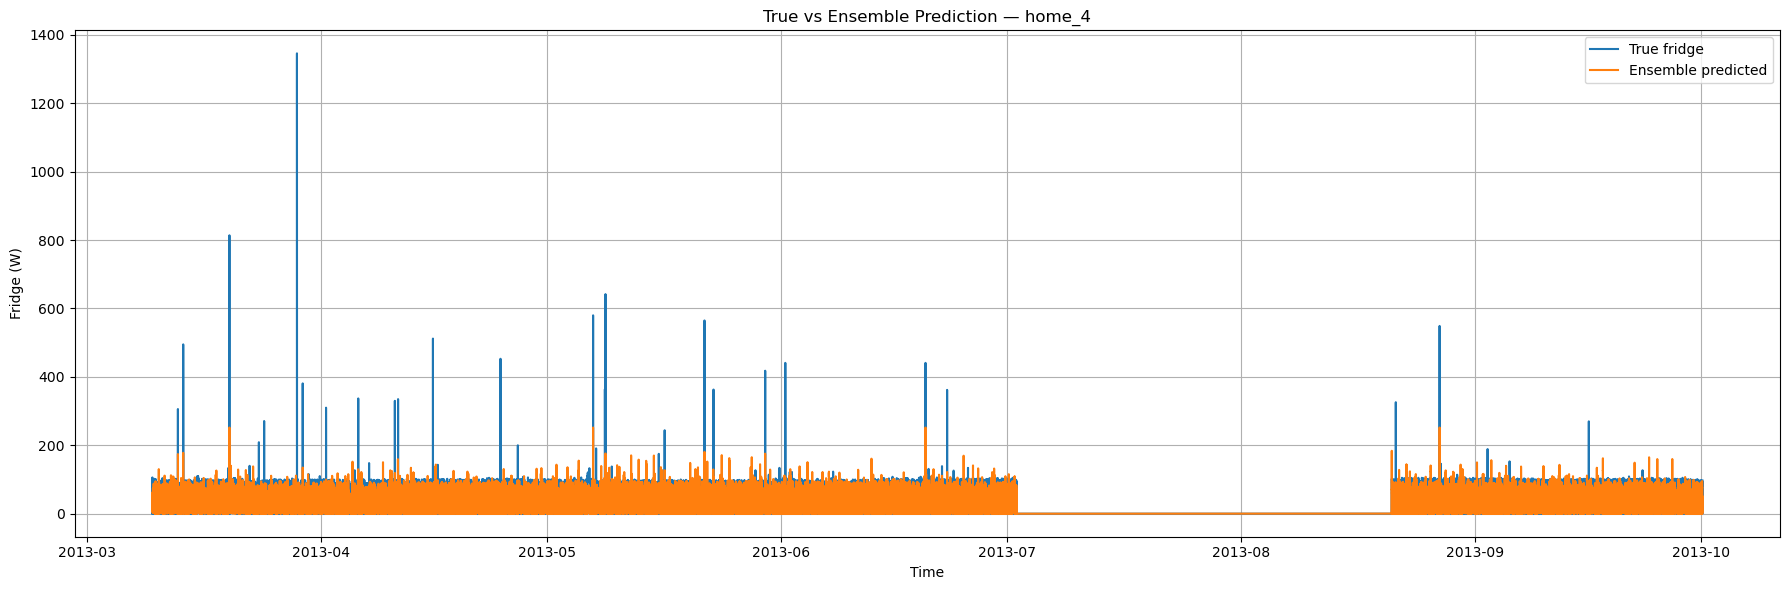

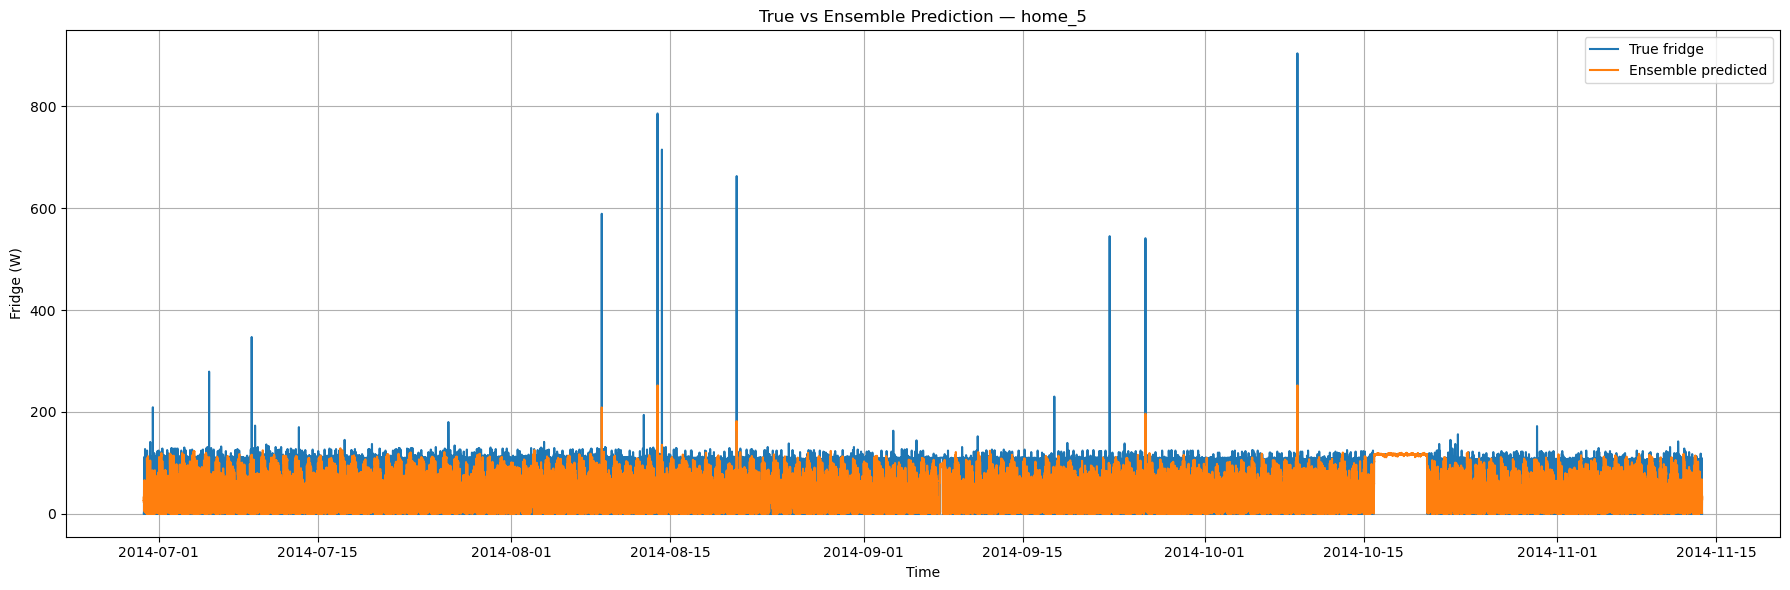

In [22]:
houses_to_plot = ["home_1", "home_2", "home_4", "home_5"]

def smooth_prob(arr, window=11):
    return (
        pd.Series(arr)
        .rolling(window, center=True, min_periods=1)
        .mean()
        .clip(0, 1)
        .values
    )

def plot_full_house(house_to_plot):

    df_house = (
        df_model[df_model["home_id"] == house_to_plot]
        .copy()
        .sort_values("datetime")
        .reset_index(drop=True)
    )

    X_house = df_house[feature_cols]
    y_house = df_house["fridge"].values
    time_all = df_house["datetime"]

    # LGBM
    reg_lgbm_h  = reg_lgbm_final.predict(X_house)
    prob_lgbm_h = cls_lgbm_final.predict_proba(X_house)[:, 1]
    prob_lgbm_hs = smooth_prob(prob_lgbm_h)

    hard_lgbm_h  = reg_lgbm_h * (prob_lgbm_hs > global_t_lgbm)
    soft_lgbm_h  = reg_lgbm_h * prob_lgbm_hs
    blend_lgbm_h = 0.5 * hard_lgbm_h + 0.5 * soft_lgbm_h

    # XGB
    reg_xgb_h  = reg_xgb_final.predict(X_house)
    prob_xgb_h = cls_xgb_final.predict_proba(X_house)[:, 1]
    prob_xgb_hs = smooth_prob(prob_xgb_h)

    hard_xgb_h  = reg_xgb_h * (prob_xgb_hs > global_t_xgb)
    soft_xgb_h  = reg_xgb_h * prob_xgb_hs
    blend_xgb_h = 0.5 * hard_xgb_h + 0.5 * soft_xgb_h

    # Final ensemble
    y_pred = w_lgbm * blend_lgbm_h + w_xgb * blend_xgb_h
    y_pred = np.clip(y_pred, 0.0, FRIDGE_MAX_SAFE)

    # Plot (FULL TIME)
    plt.figure(figsize=(18, 6))
    plt.plot(time_all, y_house, label="True fridge", linewidth=1.5)
    plt.plot(time_all, y_pred, label="Ensemble predicted", linewidth=1.5)
    plt.title(f"True vs Ensemble Prediction — {house_to_plot}")
    plt.xlabel("Time")
    plt.ylabel("Fridge (W)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ==== RUN FOR ALL 4 HOUSES ====
for h in houses_to_plot:
    plot_full_house(h)


================= LOHO PREDICTION FOR home_1 =================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 3324341, number of used features: 32
[LightGBM] [Info] Start training from score 33.753987
[LightGBM] [Info] Number of positive: 1049357, number of negative: 2274984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 3324341, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315659 -> initscore=-0.773795
[LightGBM] [Info]

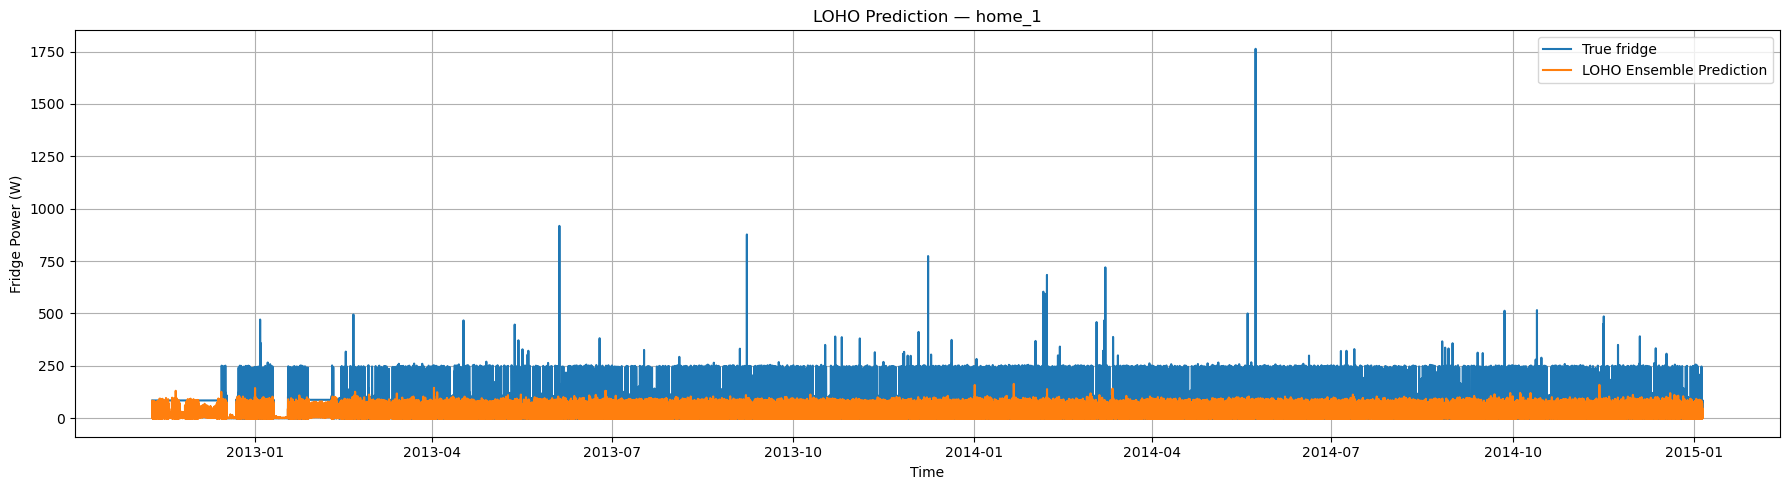


================= LOHO PREDICTION FOR home_2 =================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 6502618, number of used features: 32
[LightGBM] [Info] Start training from score 39.746175
[LightGBM] [Info] Number of positive: 2712910, number of negative: 3789708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6267
[LightGBM] [Info] Number of data points in the train set: 6502618, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.417203 -> initscore=-0.334267
[LightGBM] [Info]

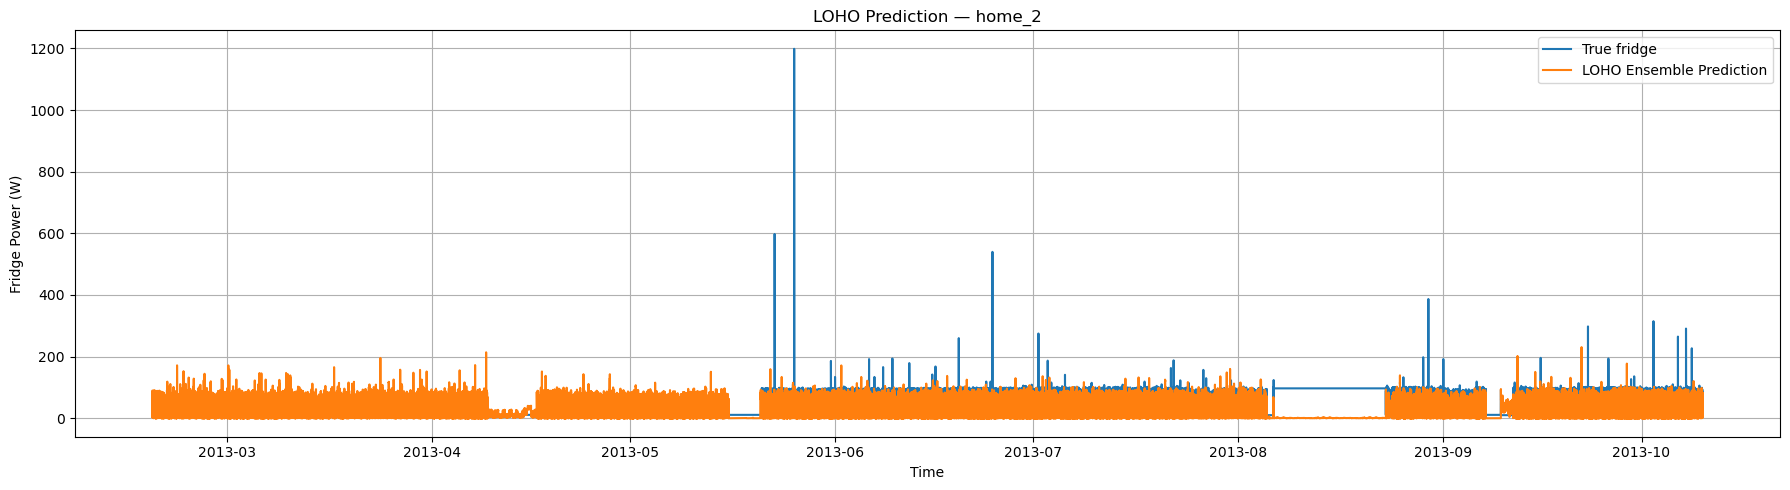


================= LOHO PREDICTION FOR home_4 =================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.206230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6266
[LightGBM] [Info] Number of data points in the train set: 6669268, number of used features: 32
[LightGBM] [Info] Start training from score 41.160661
[LightGBM] [Info] Number of positive: 2786892, number of negative: 3882376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6266
[LightGBM] [Info] Number of data points in the train set: 6669268, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.417871 -> initscore=-0.331520
[LightGBM] [Info]

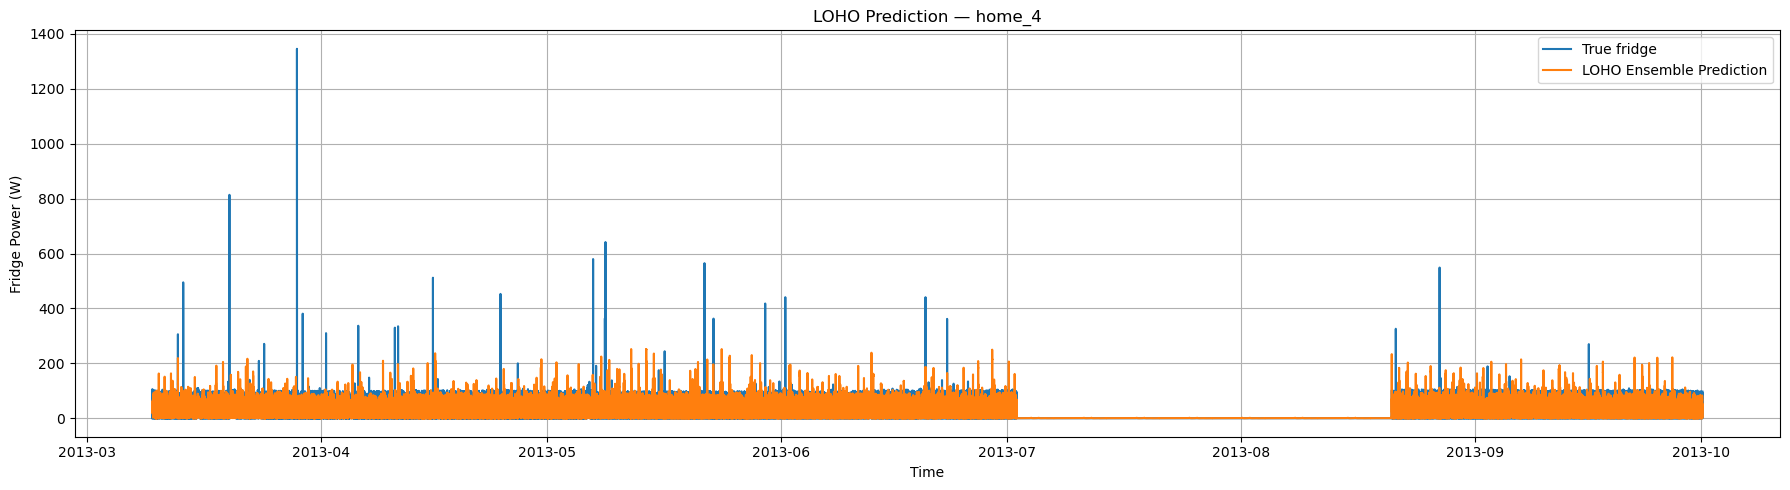


================= LOHO PREDICTION FOR home_5 =================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6266
[LightGBM] [Info] Number of data points in the train set: 7064096, number of used features: 32
[LightGBM] [Info] Start training from score 38.566890
[LightGBM] [Info] Number of positive: 2821593, number of negative: 4242503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6266
[LightGBM] [Info] Number of data points in the train set: 7064096, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399427 -> initscore=-0.407852
[LightGBM] [Info]

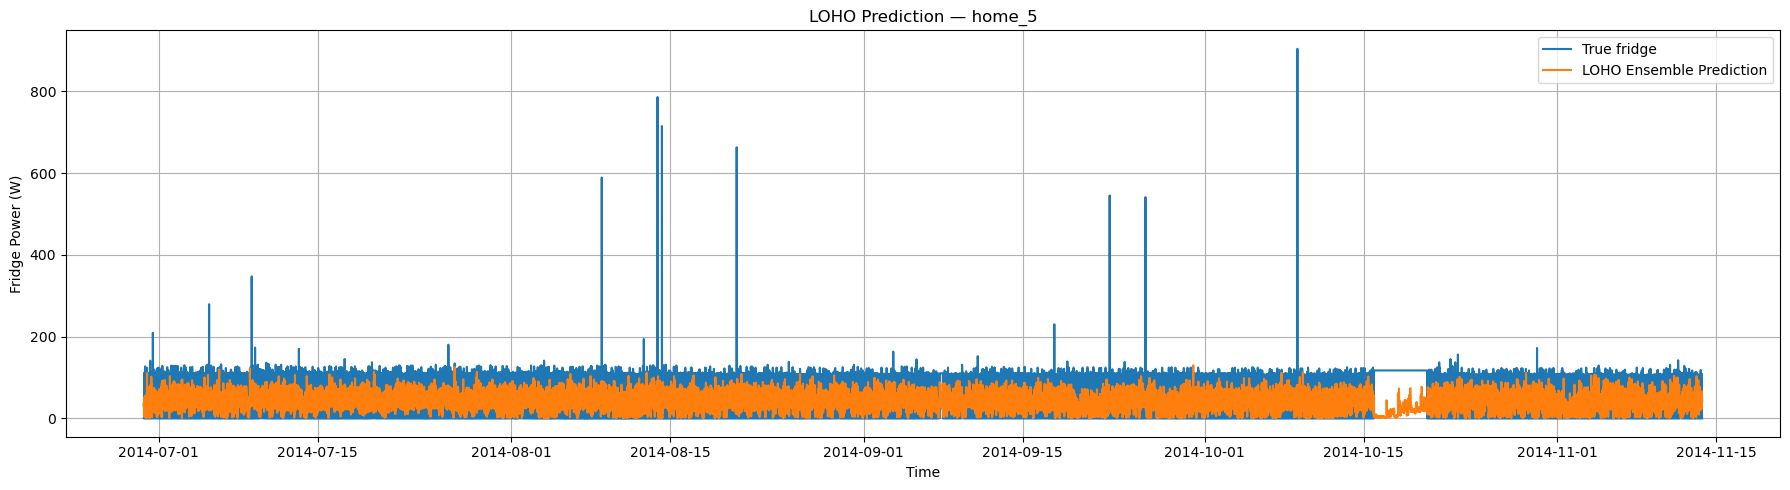

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def loho_predict_for_house(house_to_plot):
    """
    Re-trains LightGBM + XGBoost on all OTHER houses
    Then predicts on THIS house only.
    Returns true values and LOHO blended predictions.
    """

    print(f"\n================= LOHO PREDICTION FOR {house_to_plot} =================")

    # split train/valid
    train_fold = df_model[df_model["home_id"] != house_to_plot]
    valid_fold = df_model[df_model["home_id"] == house_to_plot].sort_values("datetime")

    X_train = train_fold[feature_cols]
    y_train_reg = train_fold[target_reg]
    y_train_cls = train_fold[target_cls]

    X_valid = valid_fold[feature_cols]
    y_valid_reg = valid_fold[target_reg].values
    time_valid = valid_fold["datetime"]

    # ---------------- LIGHTGBM ----------------
    reg_lgbm = lgb.LGBMRegressor(
        n_estimators=2000, learning_rate=0.03, num_leaves=64,
        subsample=0.8, colsample_bytree=0.8, min_child_samples=50,
        objective="regression", random_state=42, n_jobs=-1
    )
    reg_lgbm.fit(X_train, y_train_reg)

    cls_lgbm = lgb.LGBMClassifier(
        n_estimators=2000, learning_rate=0.03, num_leaves=64,
        subsample=0.8, colsample_bytree=0.8, min_child_samples=50,
        objective="binary", random_state=42, n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )
    cls_lgbm.fit(X_train, y_train_cls)

    reg_lgbm_pred = reg_lgbm.predict(X_valid)
    prob_lgbm = cls_lgbm.predict_proba(X_valid)[:, 1]
    prob_lgbm_s = smooth_prob(prob_lgbm)

    # best threshold from LGBM LOHO CV
    t_lgbm = results_lgbm_df["best_t"].median()

    hard_lgbm = reg_lgbm_pred * (prob_lgbm_s > t_lgbm)
    soft_lgbm = reg_lgbm_pred * prob_lgbm_s
    blend_lgbm = 0.5 * hard_lgbm + 0.5 * soft_lgbm

    # ---------------- XGBOOST ----------------
    reg_xgb = XGBRegressor(
        n_estimators=1500, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
        objective="reg:squarederror", tree_method="hist",
        eval_metric="mae", random_state=42, n_jobs=-1,
    )
    reg_xgb.fit(X_train, y_train_reg, verbose=False)

    cls_xgb = XGBClassifier(
        n_estimators=1500, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
        objective="binary:logistic", tree_method="hist",
        scale_pos_weight=scale_pos_weight, eval_metric="logloss",
        random_state=42, n_jobs=-1
    )
    cls_xgb.fit(X_train, y_train_cls, verbose=False)

    reg_xgb_pred = reg_xgb.predict(X_valid)
    prob_xgb = cls_xgb.predict_proba(X_valid)[:, 1]
    prob_xgb_s = smooth_prob(prob_xgb)

    t_xgb = results_xgb_df["best_t"].median()

    hard_xgb = reg_xgb_pred * (prob_xgb_s > t_xgb)
    soft_xgb = reg_xgb_pred * prob_xgb_s
    blend_xgb = 0.5 * hard_xgb + 0.5 * soft_xgb

    # ---------------- FINAL LOHO ENSEMBLE ----------------
    w_lgbm = 0.5
    w_xgb  = 0.5

    pred_ens = w_lgbm * blend_lgbm + w_xgb * blend_xgb
    pred_ens = np.clip(pred_ens, 0.0, FRIDGE_MAX_SAFE)

    mae_loho = mean_absolute_error(y_valid_reg, pred_ens)
    print(f"LOHO MAE for {house_to_plot}: {mae_loho:.2f} W")

    return time_valid, y_valid_reg, pred_ens


# ============================================================
#           Generate LOHO plots for ALL 4 houses
# ============================================================

houses = ["home_1", "home_2", "home_4", "home_5"]

for h in houses:
    t, y_true, y_pred = loho_predict_for_house(h)

    plt.figure(figsize=(18, 5))
    plt.plot(t, y_true, label="True fridge", linewidth=1.5)
    plt.plot(t, y_pred, label="LOHO Ensemble Prediction", linewidth=1.5)
    plt.title(f"LOHO Prediction — {h}")
    plt.xlabel("Time")
    plt.ylabel("Fridge Power (W)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()